In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import data from CSV extracted from Cassandra after Pyspark Process
pd.options.display.colheader_justify = 'right'
Data = pd.read_csv('C:\\Users\\santi\\Downloads\\Data.csv')
Data

,date,score_V
0,2009-04-06,0.116971
1,2009-04-07,0.135128
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN
...,...,...
76,2009-06-21,-0.006375
77,2009-06-22,-0.030599
78,2009-06-23,-0.024182
79,2009-06-24,-0.012015


In [86]:
#Aplly best strategy found in EDA for inputting missing data

def seasonal_mean(ts, n, lr=.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

Data['score_V'] = seasonal_mean(Data['score_V'], n=7, lr=1.05)

C:\Users\santi\AppData\Local\Temp\ipykernel_20916\1606205329.py:13: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(ts_seas)):


In [87]:
Data['date']  = pd.to_datetime(Data['date'])

In [88]:
Data['Weekday'] = Data['date'].dt.strftime('%A')
Data = Data[['score_V','Weekday']]

<AxesSubplot:ylabel='score_V'>

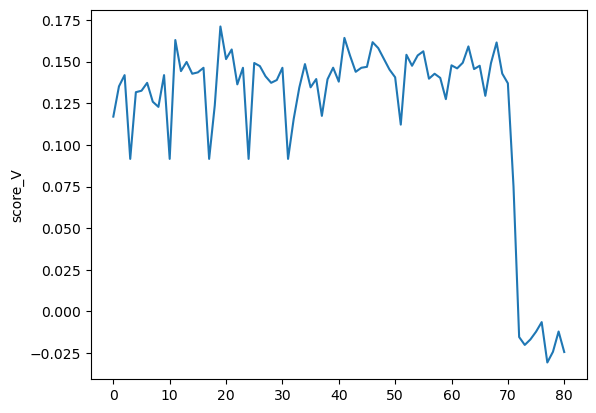

In [89]:
import seaborn
seaborn.lineplot(Data['score_V'])

In [90]:

def weekday_mapping(x):
    week = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6 }

    return week[x]

Data['Weekday'] = Data['Weekday'].apply(weekday_mapping)


C:\Users\santi\AppData\Local\Temp\ipykernel_20916\889199729.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Weekday'] = Data['Weekday'].apply(weekday_mapping)


In [91]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(Data.score_V.values, autolag='AIC')
print(f'p-value: {result[1]}')
if result[1]>.05:
    print("Null Hypothesis (HO): Series is non-stationary, or series has a unit root.")
else:
    print("Alternate Hypothesis(HA): Series is stationary, or series has no unit root.")


p-value: 0.622564960019301
Null Hypothesis (HO): Series is non-stationary, or series has a unit root.


C:\Users\santi\AppData\Local\Temp\ipykernel_20916\2492519450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['score_V'] = signal.detrend(Data['score_V'].values)


Text(0.5, 1.0, 'Detrend Vader score')

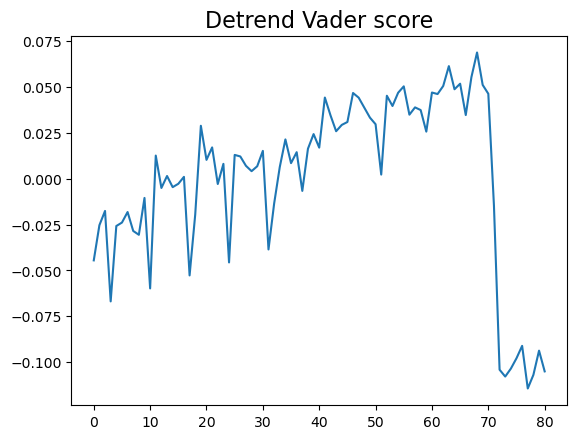

In [92]:
from scipy import signal
Data['score_V'] = signal.detrend(Data['score_V'].values)
plt.plot(Data['score_V'])
plt.title('Detrend Vader score', fontsize=16)

In [93]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(Data)
Data = scaler.transform(Data)

In [94]:
Data = pd.DataFrame(Data, columns =['score_V','Weekday']
)
Data

,score_V,Weekday
0,-0.953514,-1.468513
1,-0.543072,-0.966616
2,-0.376757,-0.464719
3,-1.431918,0.037178
4,-0.552774,0.539074
...,...,...
76,-1.950364,1.542868
77,-2.447458,-1.468513
78,-2.288403,-0.966616
79,-2.006220,-0.464719


In [95]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


steps = 40
data_train = Data[:-steps]
data_test  = Data[-steps:]



forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train["score_V"], exog=data_train["Weekday"])
forecaster

predictions = forecaster.predict(steps=steps, exog=data_test["Weekday"])

<AxesSubplot:>

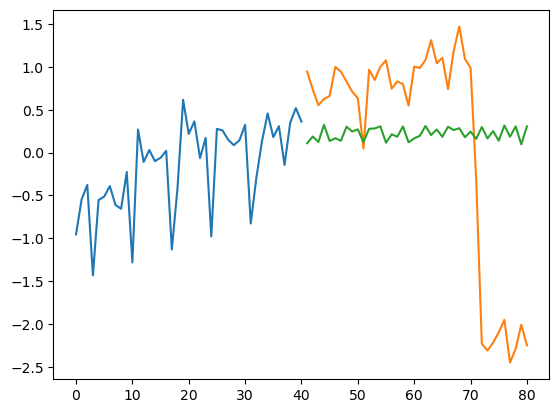

In [96]:
data_train['score_V'].plot(label='train')
data_test['score_V'].plot(label='test')
predictions.plot(label='predictions')

In [97]:
from skforecast.model_selection import grid_search_forecaster
steps = 30
data_train = Data[:-steps]
data_test  = Data[-steps:]

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7 )

lags_grid = [2,3,5,7,14]

param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5,4]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['score_V'],
                        exog        = data_train['Weekday'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
               )

predictions = forecaster.predict(steps=steps, exog=data_test['Weekday'])

Number of models compared: 30.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.1564858545725631



In [119]:
#1 week predictions

last_window = Data['score_V'][:-7]
forecaster.predict(last_window=last_window, steps=7,exog= Data['Weekday'][74:])


74    0.209221
75    0.264161
76    0.093925
77   -0.157632
78   -0.112973
79   -0.997152
80   -1.017339
Name: pred, dtype: float64

In [122]:
#1 month
last_window = Data['score_V'][:-30]
forecaster.predict(last_window=last_window, steps=30,exog= Data['Weekday'][51:])


51    0.691191
52    0.727692
53    0.872780
54    0.865487
55    0.828824
56    0.706556
57    0.678993
58    0.696966
59    0.728548
60    0.860063
61    0.867494
62    0.830908
63    0.708153
64    0.681492
65    0.696966
66    0.728548
67    0.860063
68    0.867494
69    0.830908
70    0.708153
71    0.681492
72    0.696966
73    0.728548
74    0.860063
75    0.867494
76    0.830908
77    0.708153
78    0.681492
79    0.696966
80    0.728548
Name: pred, dtype: float64

In [127]:
#3 month
last_window = Data['score_V'][:-30]
forecaster.predict(last_window=last_window, steps=90,exog= Data['Weekday'])


ValueError: `exog` must have at least as many values as the distance to the maximum step predicted, 90.